## Arduino Project - Analysing Temprature and Humidity Dataset

In [6]:
%matplotlib inline
from boto3 import client
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
dynamoDB_client = client('dynamodb')

scan_args={
    "TableName": "house-metrics",
    "ProjectionExpression": "#timestamp,#temperature,#humidity",
    "ExpressionAttributeNames": {
        "#timestamp": "timestamp",
        "#temperature": "temperature",
        "#humidity": "humidity",
    }
}

res = dynamoDB_client.scan(**scan_args)


def convert_item_to_dict(item):
    return {
        "timestamp": pd.Timestamp(item["timestamp"]["S"]),
        "temperature": int(item["temperature"]["N"]), 
        "humidity": int(item["humidity"]["N"]),
        } 

items = [convert_item_to_dict(item) for item in res["Items"]]

df = pd.DataFrame(items)

In [11]:
df.head(10)

,timestamp,temperature,humidity
0,2021-01-14 03:24:11+00:00,19,59
1,2021-01-14 18:44:24+00:00,21,55
2,2021-01-14 13:24:19+00:00,21,54
3,2021-01-14 13:04:19+00:00,20,55
4,2021-01-13 23:44:08+00:00,24,51
5,2021-01-14 02:44:10+00:00,20,59
6,2021-01-14 04:24:12+00:00,19,59
7,2021-01-14 20:44:26+00:00,20,58
8,2021-01-14 14:44:21+00:00,22,56
9,2021-01-14 04:04:11+00:00,19,59


In [12]:
# Cleaning & Sorting
df.dropna(inplace=True)
df.sort_values(by=["timestamp"], inplace = True)

temp=df["temperature"]
humidity=df["humidity"]
timestamp=df["timestamp"]
temp_df=pd.DataFrame(temp)
humidity_df=pd.DataFrame(humidity)

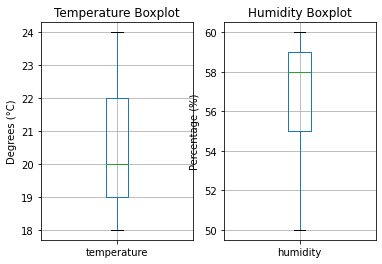

In [13]:
# Boxplots
plt.subplot(1,2,1)
plt.title("Temperature Boxplot")
temp_df.boxplot()
plt.ylabel("Degrees (°C)")
plt.subplot(1,2,2)
plt.title("Humidity Boxplot")
humidity_df.boxplot()
plt.ylabel("Percentage (%)")
plt.show()

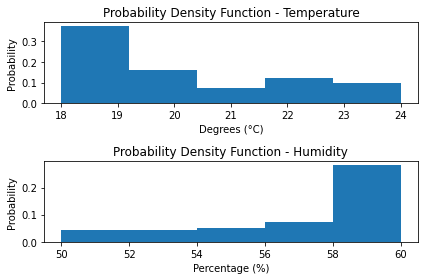

In [23]:
# Histograms
histograms_fig = plt.figure()

histograms_temp_ax = histograms_fig.add_subplot(2,1,1)
histograms_temp_ax.set_title("Probability Density Function - Temperature")

histograms_temp_ax.set_xlabel("Degrees (°C)")
histograms_temp_ax.set_ylabel("Probability")
histograms_temp_ax.hist(temp, density=True, align='mid', bins='scott')

histograms_humidity_ax = histograms_fig.add_subplot(2,1,2)
histograms_humidity_ax.set_title("Probability Density Function - Humidity")
histograms_humidity_ax.set_xlabel("Percentage (%)")
histograms_humidity_ax.set_ylabel("Probability")
histograms_humidity_ax.hist(humidity_df,density=True, align='mid', bins='scott')

histograms_fig.tight_layout()
plt.show()

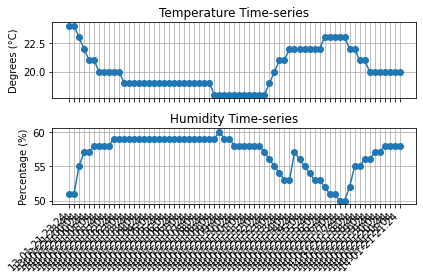

In [26]:
# Timeseries
timeseries_fig = plt.figure()
temp_timeseries_ax = timeseries_fig.add_subplot(2,1,1)

temp_timeseries_ax.set_xticks(timestamp)
temp_timeseries_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
temp_timeseries_ax.set_title("Temperature Time-series")
temp_timeseries_ax.plot_date(timestamp, temp, ls='-', marker='o')
temp_timeseries_ax.set_ylabel("Degrees (°C)")
temp_timeseries_ax.grid(True)

humidity_timeseries_ax = timeseries_fig.add_subplot(2,1,2)
humidity_timeseries_ax.set_xticks(timestamp)
humidity_timeseries_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
humidity_timeseries_ax.set_title("Humidity Time-series")
humidity_timeseries_ax.plot_date(timestamp, humidity_df, ls='-', marker='o')
humidity_timeseries_ax.set_ylabel("Percentage (%)")
humidity_timeseries_ax.grid(True)

timeseries_fig.autofmt_xdate(rotation=45)
timeseries_fig.tight_layout()
plt.show()

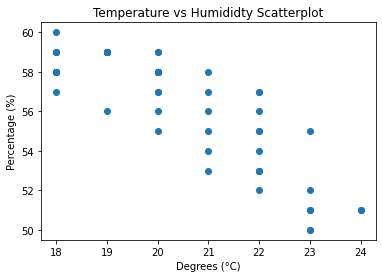

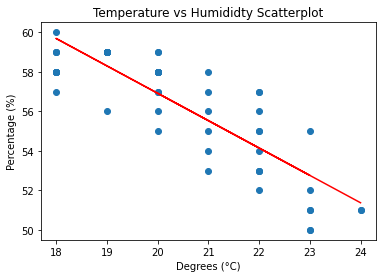

In [25]:
# Scatterplots
scatterplot_fig = plt.figure()

temp_humidity_axes = scatterplot_fig.add_subplot(1,1,1)
temp_humidity_axes.set_xlabel("Degrees (°C)")
temp_humidity_axes.set_ylabel("Percentage (%)")
temp_humidity_axes.set_title("Temperature vs Humididty Scatterplot")
temp_humidity_axes.scatter(temp_df, humidity_df, marker='o')
plt.show()

# correlation matrix

pd.DataFrame(data = {
    "temperature": temp_df['temperature'].values,
    "humidity": humidity_df["humidity"].values,
}).corr()

# Linear Regression
from sklearn import linear_model
model = linear_model.LinearRegression()

model.fit(temp_df, humidity_df)

# humidity = -1.3848 * temperature + 84.6117
model.coef_
model.intercept_

# R-squared - 0.7317
model.score(temp_df, humidity_df)

scatterplot_with_model_fig = plt.figure()

scatterplot_with_model_fig_axes = scatterplot_with_model_fig.add_subplot(1,1,1)
scatterplot_with_model_fig_axes.set_xlabel("Degrees (°C)")
scatterplot_with_model_fig_axes.set_ylabel("Percentage (%)")
scatterplot_with_model_fig_axes.set_title("Temperature vs Humididty Scatterplot")
scatterplot_with_model_fig_axes.scatter(temp_df, humidity_df, marker='o')
scatterplot_with_model_fig_axes.plot(temp_df, model.predict(temp_df), linestyle='-', color='r')
plt.show()